In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101  , preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

2022-12-27 17:53:28.717035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-27 17:53:39.210353: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-27 17:53:39.298911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-27 17:53:39.415468: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-27 17:53:39.415541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lnx00273.ad.liu.se
2022-12-27 17:53:39.415555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lnx00273.ad.liu.se
2022-12-27 17:53:39.415713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2022-12-27 17:53:3

In [2]:
datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.1,
    #featurewise_center=True,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    brightness_range=[0.90,1.25],
    #fill_mode='nearest'
)

In [3]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('/local/data1/chash345/train', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=True,
    #color_mode='rgb'
)


# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('/local/data1/chash345/valid', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32, 
    shuffle=False,
    #color_mode='rgb'
)


# load and iterate test dataset
test_data = datagenerator.flow_from_directory('/local/data1/chash345/test', 
    class_mode= None,
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False,
    #color_mode='rgb'
)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 151.0610 and the minimum is -123.6800
The mean value of the pixels is -21.2303 and the standard deviation is 85.8219


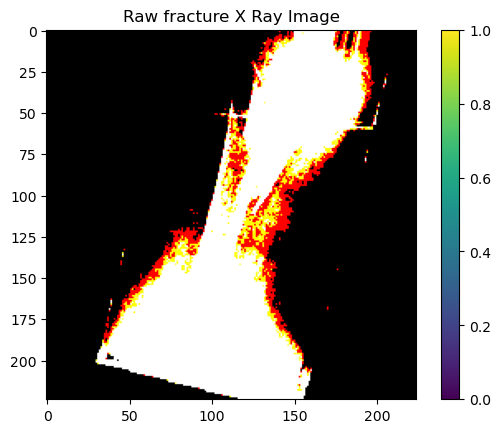

In [5]:
#sns.set_style('white')
generated_image, label = train_data.__getitem__(20)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw fracture X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [6]:
generated_image.shape

(32, 224, 224, 3)

In [7]:
pre_trained_model_resnet152 = ResNet101(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

2022-12-27 15:48:18.010406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 15:48:18.010664: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


171450368/171446536 [==============================] - 6s 0us/step


In [8]:
# Some weights in later layers are unfreezed
for layer in pre_trained_model_resnet152.layers:
    layer.trainable=False

tf.random.set_seed(150)

model = tf.keras.models.Sequential([
    pre_trained_model_resnet152,
    GlobalAveragePooling2D(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    #Dense(256,activation="relu"),
    #Dropout(0.4),
    Dense(128, activation='swish'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 43,773,057
Trainable params: 1,114,881
Non-trainable params: 42,658,176
____________________________________

In [10]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))
dict_weights = {0: weights[0], 1:weights[1]}
dict_weights

{0: 2.5, 1: 0.625}

In [ ]:
history = model.fit( train_data, 
validation_data= val_data, 
epochs= 20, 
verbose=1, 
class_weight=dict_weights
)

In [ ]:
model = model.save('saved_model')


In [4]:
reconstructed_model = keras.models.load_model("saved_model")

2022-12-27 17:53:48.263692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 17:53:48.263905: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
predcited_classes = reconstructed_model.predict_classes(test_data)

/home/chash345/.conda/envs/research/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-12-27 17:54:13.506390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-27 17:54:13.506793: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


In [6]:
predicted_probs = reconstructed_model.predict(test_data)

In [7]:
# %%
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

# %%
fpr, tpr, thresholds = roc_curve(test_data.classes, predcited_classes)

In [8]:
# %%
roc_auc_score(test_data.classes, predicted_probs )


0.7826723438428012

In [9]:
# %%
roc_auc_score(test_data.classes, predcited_classes )

0.7188124775185498

In [10]:
roc_auc = auc(fpr, tpr)

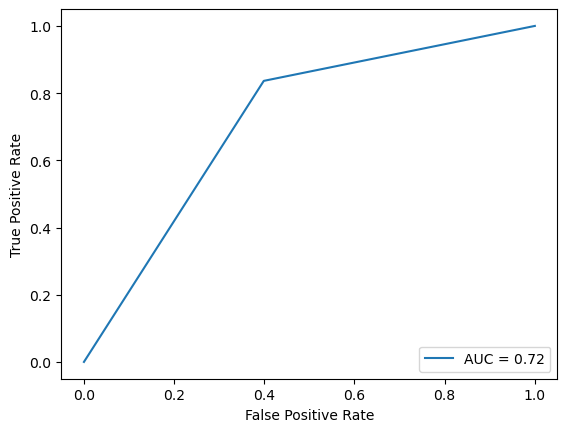

In [11]:
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()